In [1]:
# General Libs
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
TRAIN_DIR = 'C:/Users/AGM/UDSculptureDataSet/Data/Train/Train'
VAL_DIR = 'C:/Users/AGM/UDSculptureDataSet/Data/Validation/Validation'
TEST_DIR = 'C:/Users/AGM/UDSculptureDataSet/Data/Test/Test'

In [3]:
categories = ['CHRIST THE TEACHER','DANTE','HAIL MARY','HONOR ROLL','JANE AUSTEN',
              'JOHN F KENNEDY','KAPPA ALPHA PSI','KNIGHT BY BROTHER MEL','LADY OF THE PINES',
              'MARTIN LUTHER KING JR','MARY LOUISA','MARY OF CANA','MARY SEAT OF WISDOM',
              'MOSES MAIMONIDES','OMEGA POINT','RED CUBE','SERENITY PINES','THE HOLY FAMILY',
              'THOMAS EQUINAS','THRONE BY BROTHER MEL','TRUSTING IN DREAMS',
              'WILLIAM JOSEPH CHAMINADE','WILLIAM SHAKESPEARE','WOLFGANG AMADEUS MOZART']

category_embeddings = {'CHRIST THE TEACHER': 0,'DANTE': 1,'HAIL MARY': 2,'HONOR ROLL': 3,'JANE AUSTEN': 4,
                       'JOHN F KENNEDY': 5,'KAPPA ALPHA PSI': 6,'KNIGHT BY BROTHER MEL': 7,'LADY OF THE PINES': 8,
                       'MARTIN LUTHER KING JR': 9,'MARY LOUISA': 10,'MARY OF CANA': 11,'MARY SEAT OF WISDOM': 12,
                       'MOSES MAIMONIDES': 13,'OMEGA POINT': 14,'RED CUBE': 15,'SERENITY PINES': 16,'THE HOLY FAMILY': 17,
                       'THOMAS EQUINAS': 18,'THRONE BY BROTHER MEL': 19,'TRUSTING IN DREAMS': 20,
                       'WILLIAM JOSEPH CHAMINADE': 21,'WILLIAM SHAKESPEARE': 22,'WOLFGANG AMADEUS MOZART': 23}

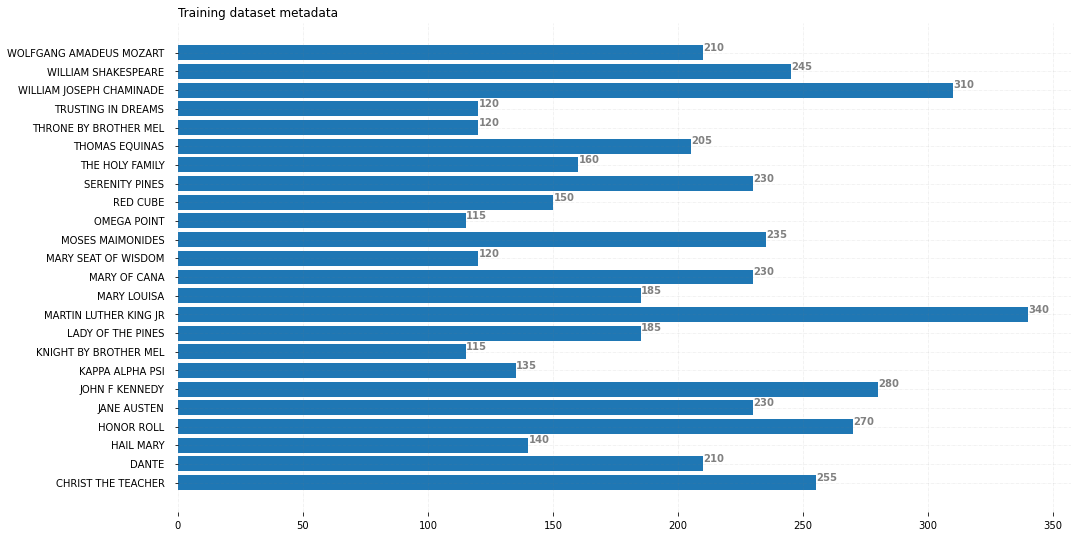

In [4]:
# training dataset metadata
n_imgs = []
for cat in categories:
    files = os.listdir(os.path.join(TRAIN_DIR, cat))
    n_imgs += [len(files)]    
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(categories, n_imgs)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+0.2,i.get_y()+0.5, str(round((i.get_width()), 2)),fontsize = 10, 
             fontweight ='bold',color ='grey')
ax.set_title('Training dataset metadata',loc ='left', )
plt.show()

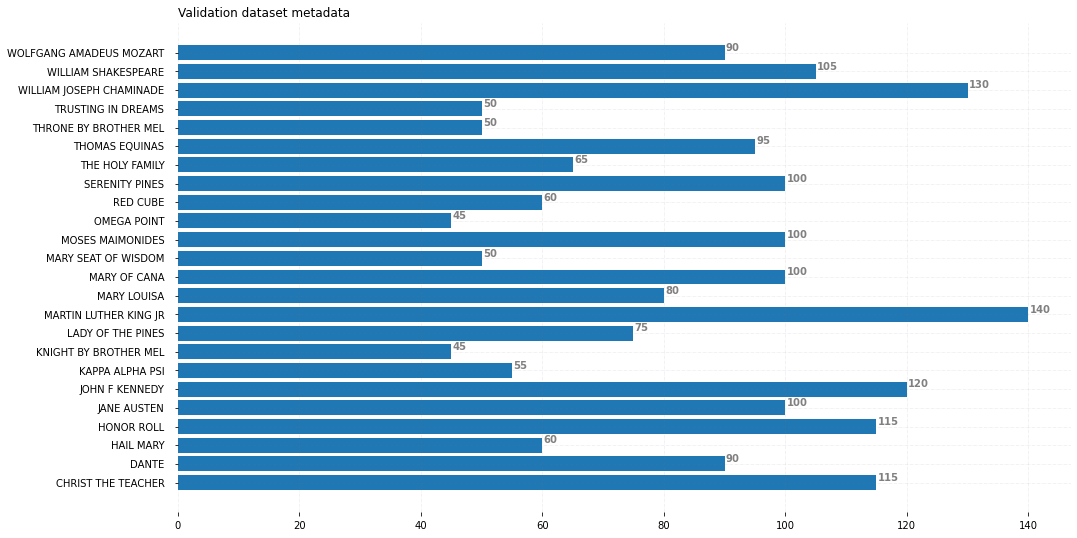

In [5]:
# validation dataset metadata
n_imgs = []
for cat in categories:
    files = os.listdir(os.path.join(VAL_DIR, cat))
    n_imgs += [len(files)]   
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(categories, n_imgs)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+0.2,i.get_y()+0.5, str(round((i.get_width()), 2)),fontsize = 10, 
             fontweight ='bold',color ='grey')
ax.set_title('Validation dataset metadata',loc ='left', )
plt.show()

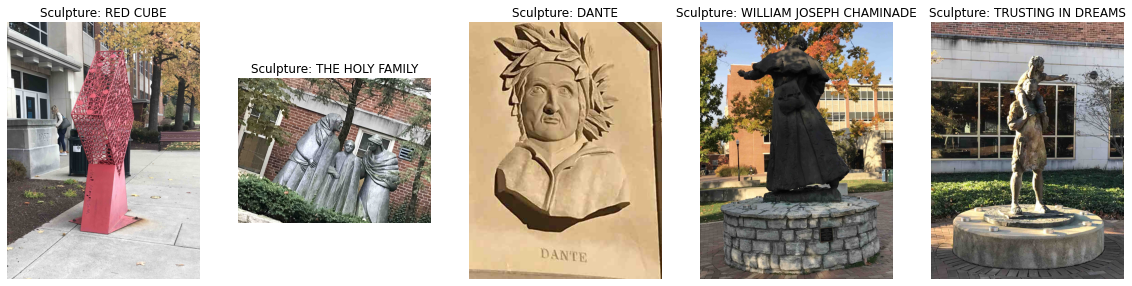

In [6]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_sculpture = random.choice(categories)
    random_image = random.choice(os.listdir(os.path.join(TEST_DIR, random_sculpture)))
    random_image_file = os.path.join(TEST_DIR, random_sculpture, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Sculpture: " + random_sculpture.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [7]:
BATCH_SIZE = 34
IMG_SHAPE = (224,224)

train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range = 90)
val_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range = 90)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        batch_size=BATCH_SIZE,
        target_size=IMG_SHAPE,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        batch_size=BATCH_SIZE,
        target_size=IMG_SHAPE,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        batch_size=BATCH_SIZE,
        target_size=IMG_SHAPE,
        class_mode="categorical")    


dirs = train_generator.class_indices
rdirs = {v:k  for k,v in dirs.items()}

Found 4795 images belonging to 24 classes.
Found 2035 images belonging to 24 classes.
Found 480 images belonging to 24 classes.


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

metric = 'val_loss'
checkpoint = ModelCheckpoint(
    filepath=r"C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1/{}".format("saved_UDsculpModel1"), 
    monitor=metric,
    verbose=1, 
    save_best_only=True)

early = EarlyStopping(
    monitor=metric, 
    min_delta=0, 
    patience=2, 
    verbose=1, 
    mode='auto')

In [9]:
import tensorflow_hub as hub
model_handle = "https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2"

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMG_SHAPE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(24, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMG_SHAPE+(3,))
model.summary()

model.compile(
  #optimizer=Adam(learning_rate = 0.001),
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              11837936  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                30744     
Total params: 11,868,680
Trainable params: 30,744
Non-trainable params: 11,837,936
_________________________________________________________________


In [10]:
EPOCHS = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    #steps_per_epoch=100, #steps_per_epoch=(data_samples/batch_size),
    epochs=EPOCHS,
    validation_steps=10,
    callbacks=[checkpoint],
    verbose=1)

Epoch 1/20
142/142 [==============================] - 828s 6s/step - loss: 1.4208 - accuracy: 0.6046 - val_loss: 0.8044 - val_accuracy: 0.7794

Epoch 00001: val_loss improved from inf to 0.80437, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 2/20
142/142 [==============================] - 840s 6s/step - loss: 0.5917 - accuracy: 0.8371 - val_loss: 0.5777 - val_accuracy: 0.8471

Epoch 00002: val_loss improved from 0.80437 to 0.57767, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 3/20
142/142 [==============================] - 783s 6s/step - loss: 0.4431 - accuracy: 0.8880 - val_loss: 0.4467 - val_accuracy: 0.8735

Epoch 00003: val_loss improved from 0.57767 to 0.44666, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 4/20
142/142 [==============================] - 815s 6s/step - loss: 0.4169 - accuracy: 0.8888 - val_loss: 0.4198 - val_accuracy: 0.8941

Epoch 00004: val_loss improved from 0.44666 to 0.41985, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 5/20
142/142 [==============================] - 831s 6s/step - loss: 0.3208 - accuracy: 0.9174 - val_loss: 0.3526 - val_accuracy: 0.9118

Epoch 00005: val_loss improved from 0.41985 to 0.35264, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 6/20
142/142 [==============================] - 851s 6s/step - loss: 0.2982 - accuracy: 0.9197 - val_loss: 0.3719 - val_accuracy: 0.8882

Epoch 00006: val_loss did not improve from 0.35264
Epoch 7/20
142/142 [==============================] - 830s 6s/step - loss: 0.2761 - accuracy: 0.9278 - val_loss: 0.3138 - val_accuracy: 0.9294

Epoch 00007: val_loss improved from 0.35264 to 0.31382, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 8/20
142/142 [==============================] - 718s 5s/step - loss: 0.2518 - accuracy: 0.9343 - val_loss: 0.2610 - val_accuracy: 0.9265

Epoch 00008: val_loss improved from 0.31382 to 0.26104, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 9/20
142/142 [==============================] - 699s 5s/step - loss: 0.2463 - accuracy: 0.9360 - val_loss: 0.3096 - val_accuracy: 0.9118

Epoch 00009: val_loss did not improve from 0.26104
Epoch 10/20
142/142 [==============================] - 703s 5s/step - loss: 0.2275 - accuracy: 0.9395 - val_loss: 0.3199 - val_accuracy: 0.9206

Epoch 00010: val_loss did not improve from 0.26104
Epoch 11/20
142/142 [==============================] - 661s 5s/step - loss: 0.2400 - accuracy: 0.9349 - val_loss: 0.2061 - val_accuracy: 0.9412

Epoch 00011: val_loss improved from 0.26104 to 0.20614, saving model to C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1
INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 12/20
142/142 [==============================] - 705s 5s/step - loss: 0.2162 - accuracy: 0.9429 - val_loss: 0.3327 - val_accuracy: 0.9059

Epoch 00012: val_loss did not improve from 0.20614
Epoch 13/20
142/142 [==============================] - 745s 5s/step - loss: 0.2048 - accuracy: 0.9462 - val_loss: 0.3157 - val_accuracy: 0.9206

Epoch 00013: val_loss did not improve from 0.20614
Epoch 14/20
142/142 [==============================] - 696s 5s/step - loss: 0.2054 - accuracy: 0.9408 - val_loss: 0.3108 - val_accuracy: 0.9088

Epoch 00014: val_loss did not improve from 0.20614
Epoch 15/20
142/142 [==============================] - 684s 5s/step - loss: 0.1946 - accuracy: 0.9497 - val_loss: 0.2320 - val_accuracy: 0.9265

Epoch 00015: val_loss did not improve from 0.20614
Epoch 16/20
142/142 [==============================] - 686s 5s/step - loss: 0.1906 - accuracy: 0.9483 - val_loss: 0.2754 - val_accuracy: 0.9265

Epoch 00016: val_loss did not improve from 0.20614
Epoch 17/20
142/142 

INFO:tensorflow:Assets written to: C:/Users/AGM/UDSculptureDataSet/FinalModelTrains/Final1\saved_UDsculpModel1\assets


Epoch 19/20
142/142 [==============================] - 700s 5s/step - loss: 0.1768 - accuracy: 0.9541 - val_loss: 0.2306 - val_accuracy: 0.9235

Epoch 00019: val_loss did not improve from 0.19424
Epoch 20/20
142/142 [==============================] - 707s 5s/step - loss: 0.1734 - accuracy: 0.9562 - val_loss: 0.2041 - val_accuracy: 0.9412

Epoch 00020: val_loss did not improve from 0.19424


In [11]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15/15 [==============================] - 106s 7s/step - loss: 0.3956 - accuracy: 0.8813
Test loss: 0.3955828547477722
Test accuracy: 0.8812500238418579


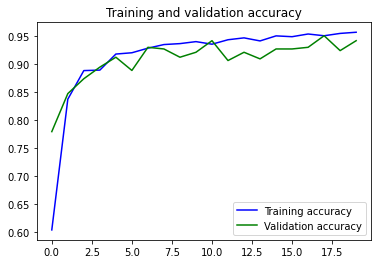

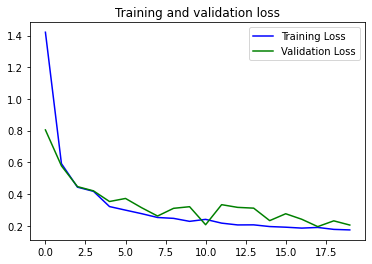

In [12]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
plot_result(history)

In [13]:
import skimage.io
import skimage.transform

from sklearn.metrics import classification_report

width = 224
height = 224
n_channels = 3

test_data = []
for cat in categories:
    files = os.listdir(os.path.join(TEST_DIR, cat))
    for file in files:
        test_data += [(os.path.join(cat, file), cat)]

X_test = []
y_test = []
for t in test_data:
    try:
        img = skimage.io.imread(os.path.join(TEST_DIR, t[0]))
        img = skimage.transform.resize(img, (width, height, n_channels), mode='reflect')
        X_test += [img]
        y_test += [category_embeddings[t[1]]]
    except OSError:
        pass

X_test = np.array(X_test)
y_test = np.array(y_test)

pred = model.predict(X_test, verbose=1)

y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred, target_names=categories))

15/15 [==============================] - 46s 3s/step
                          precision    recall  f1-score   support

      CHRIST THE TEACHER       0.79      0.95      0.86        20
                   DANTE       0.81      0.85      0.83        20
               HAIL MARY       1.00      1.00      1.00        20
              HONOR ROLL       0.91      1.00      0.95        20
             JANE AUSTEN       0.51      1.00      0.68        20
          JOHN F KENNEDY       0.90      0.95      0.93        20
         KAPPA ALPHA PSI       1.00      0.85      0.92        20
   KNIGHT BY BROTHER MEL       1.00      1.00      1.00        20
       LADY OF THE PINES       0.95      1.00      0.98        20
   MARTIN LUTHER KING JR       0.95      0.90      0.92        20
             MARY LOUISA       0.95      0.90      0.92        20
            MARY OF CANA       1.00      0.85      0.92        20
     MARY SEAT OF WISDOM       1.00      0.85      0.92        20
        MOSES MAIMONID

Text(0.5, 39.64999999999995, 'Predicted label')

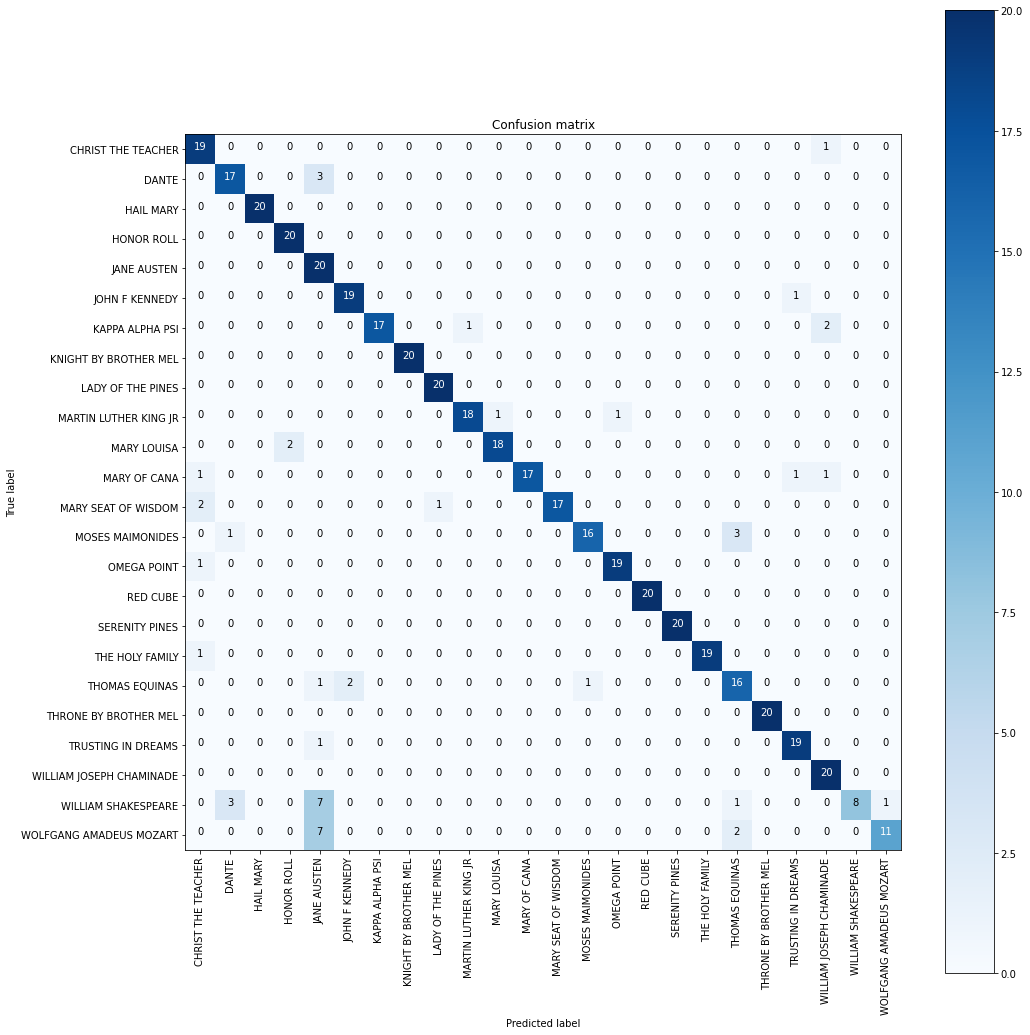

In [14]:
import itertools
from sklearn.metrics import confusion_matrix

#Confution Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=90)
plt.yticks(tick_marks, categories)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

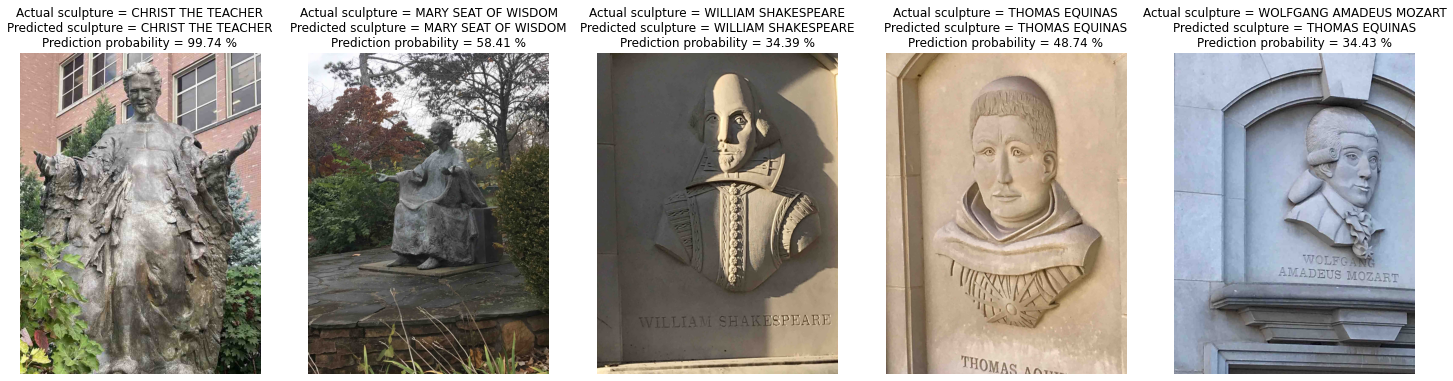

In [15]:
# Prediction
from keras.preprocessing import *
from PIL import Image

n = 5
train_input_shape = (224,224)
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_sculpture = random.choice(categories)
    random_image = random.choice(os.listdir(os.path.join(TEST_DIR, random_sculpture)))
    random_image_file = os.path.join(TEST_DIR, random_sculpture, random_image)

    test_image = Image.open(random_image_file) 
    test_image = test_image.resize(train_input_shape[0:2])

    test_image = np.array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual sculpture = {}\nPredicted sculpture = {}\nPrediction probability = {:.2f} %" \
                .format(random_sculpture.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

Predicted sculpture = WILLIAM JOSEPH CHAMINADE
Prediction probability = 87.0437502861023 %


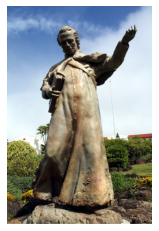

In [16]:
# Prediction
import imageio
import cv2

TEST_SCULP = 'C:/Users/AGM/UDSculptureDataSet/Data/Test/Test1/WILLIAM JOSEPH CHAMINADE/1chaminadestatue.jpg'
web_image = imageio.imread(TEST_SCULP)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted sculpture =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(TEST_SCULP))
plt.axis('off')
plt.show()

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('UDsculpModel1.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\AGM\AppData\Local\Temp\tmp9cgzxjvx\assets


INFO:tensorflow:Assets written to: C:\Users\AGM\AppData\Local\Temp\tmp9cgzxjvx\assets


In [18]:
!python -m tf2onnx.convert --opset 11 --tflite UDsculpModel1.tflite --output UDsculpModel1.onnx

2021-11-27 08:48:21.304800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-27 08:48:21.304865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-27 08:48:34.498589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-11-27 08:48:34.498644: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-27 08:48:34.512431: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-Q71RPT3
2021-11-27 08:48:34.513085: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-Q71RPT3
2021-11-27 08:48:34.514389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is